In [1]:
import random

from PIL import Image

import torch
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

from datasets import BinaryKeyboardSegmentationDataset
from datasets.util import *
from utils import get_device, imshow

In [2]:
device = get_device()
device

'mps'

In [3]:
DATASET_VERSION = 3
image_paths = get_dataset_paths(DATASET_VERSION)
len(image_paths)

2004

In [4]:
mean, std = get_dataset_norm_params(DATASET_VERSION)
mean, std

(array([0.26772413, 0.28418145, 0.28728417]),
 array([0.24711585, 0.24890053, 0.25881228]))

In [5]:
train_paths, test_paths, valid_paths = split_train_test_valid(image_paths, 0.8, 0.1)

SIZE = (480, 640)

train_dataset = BinaryKeyboardSegmentationDataset(train_paths, size=SIZE)
valid_dataset = BinaryKeyboardSegmentationDataset(valid_paths, size=SIZE)
test_dataset = BinaryKeyboardSegmentationDataset(test_paths, size=SIZE)

len(train_dataset), len(valid_dataset), len(test_dataset)

  0%|          | 0/1403 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/401 [00:00<?, ?it/s]

(1403, 200, 401)

In [6]:
train_dataset.set_transforms([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    # transforms.RandomErasing(p=0.5),
])

train_dataset.set_augmentations([
    # transforms.RandomChannelPermutation(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.Normalize(mean, std),
])

valid_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

test_dataset.set_augmentations([
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

539 (3, 480, 640)


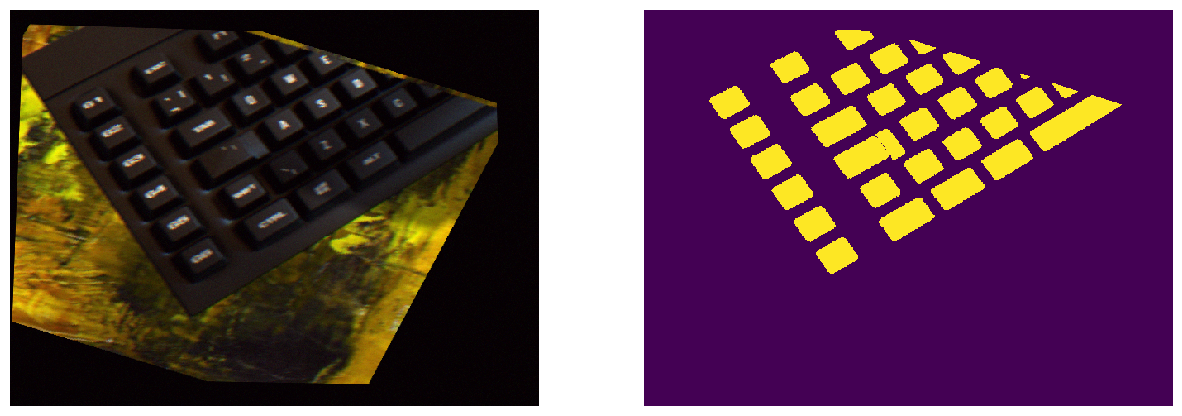

In [7]:
i = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[i]

print(i, tuple(img.shape))
imshow(img, mask, figsize=(15, 30))

In [104]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dl_kwargs = {"batch_size": BATCH_SIZE, "num_workers": 2, "persistent_workers": True, "pin_memory": True}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)
test_dataloader = DataLoader(test_dataset, **dl_kwargs)

In [9]:
img, mask = next(iter(train_dataloader))
img.dtype, mask.dtype

(torch.float32, torch.bool)

In [139]:
import segmentation_models_pytorch as smp
from scipy.ndimage import distance_transform_edt as edt


class HausdorffDTLoss(torch.nn.Module):
    """Binary Hausdorff loss based on distance transform"""

    def __init__(self, alpha=2.0, **kwargs):
        super(HausdorffDTLoss, self).__init__()
        self.alpha = alpha

    @torch.no_grad()
    def distance_field(self, img):
        field = np.zeros_like(img)

        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5

            if fg_mask.any():
                bg_mask = ~fg_mask

                fg_dist = edt(fg_mask)
                bg_dist = edt(bg_mask)

                field[batch] = fg_dist + bg_dist

        return field

    def forward(self, pred: torch.Tensor, target: torch.Tensor, debug=False):
        """
        Uses one binary channel: 1 - fg, 0 - bg
        pred: (b, 1, x, y, z) or (b, 1, x, y)
        target: (b, 1, x, y, z) or (b, 1, x, y)
        """
        assert pred.dim() == 4 or pred.dim() == 5, "Only 2D and 3D supported"
        assert (
                pred.dim() == target.dim()
        ), "Prediction and target need to be of same dimension"

        pred = torch.sigmoid(pred)

        pred_dt = torch.from_numpy(self.distance_field(pred.cpu().numpy())).float()
        target_dt = torch.from_numpy(self.distance_field(target.cpu().numpy())).float()

        pred_error = (pred - target) ** 2
        distance = pred_dt ** self.alpha + target_dt ** self.alpha

        dt_field = pred_error * distance
        loss = dt_field.mean()

        return loss


class BinarySegmentationModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()

        self.model = smp.create_model(arch, encoder_name, in_channels=in_channels, classes=out_classes, **kwargs)
        # self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.loss_fn = smp.losses.MCCLoss()

        self.learning_rate = LEARNING_RATE
        self.lr = self.learning_rate
        self.save_hyperparameters()

    def forward(self, image):
        return self.model(image)

    def _step(self, batch, stage):
        if wandb.run is not None and trainer.global_step == 0:
            wandb.define_metric(f"{stage}_loss", summary="min")

        image, truth = batch
        prediction = self.forward(image)

        loss = self.loss_fn(prediction, truth.int())
        self.log(f"{stage}_loss", loss)
        return loss

        # prob_mask = logits_mask.sigmoid()
        # pred_mask = (prob_mask > 0.5).float()

        # True/False positives/negatives
        # tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        # return {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn}

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=(self.lr or self.learning_rate))

        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STEPS, eta_min=1e-5)
        return {"optimizer": optimizer}  # "lr_scheduler": {"scheduler": scheduler, "interval": "step", "frequency": 1}

In [122]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [141]:
ARCH = "unetplusplus"
BACKBONE = "timm-regnetx_002"

LEARNING_RATE = 2e-4

wandb.finish()
model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1, encoder_weights="imagenet")
model

BinarySegmentationModel(
  (model): UnetPlusPlus(
    (encoder): RegNetEncoder(
      (stem): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (s1): RegStage(
        (b1): Bottleneck(
          (conv1): ConvNormAct(
            (conv): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
          )
          (conv2): ConvNormAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, trac

In [142]:
summarize(model)

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | UnetPlusPlus | 5.2 M  | train
1 | loss_fn | MCCLoss      | 0      | train
-------------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.753    Total estimated model params size (MB)
440       Modules in train mode
0         Modules in eval mode

In [143]:
EPOCHS = 100

PROFILE = False
profiler = "advanced" if PROFILE else None

logger = WandbLogger(project="mrover-keyboard-region-segmentation", group=f"DatasetV{DATASET_VERSION}")
logger.experiment.config["dataset"] = DATASET_VERSION
# logger.watch(model, log="all", log_freq=len(train_dataloader))

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, logger=logger,
                     callbacks=[checkpoint_callback], profiler=profiler, limit_train_batches=20)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | model   | UnetPlusPlus | 5.2 M  | train
1 | loss_fn | MCCLoss      | 0      | train
-------------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.753    Total estimated model params size (MB)
440       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [41]:
checkpoint = torch.load("mrover-keyboard-region-segmentation/1gf02ro3/checkpoints/epoch=57-step=1160.ckpt", weights_only=True)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [108]:
torch.save(model.state_dict(), f"models/binary_segmentation/{wandb.run.name}-{ARCH}-{BACKBONE}-v{DATASET_VERSION}.pt")

In [77]:
ARCH = "unetplusplus"
BACKBONE = "resnet18"
name = "jumping-darkness-67"

LEARNING_RATE = None

model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1)
model.load_state_dict(torch.load(f"models/binary_segmentation/{name}-{ARCH}-{BACKBONE}-v{DATASET_VERSION}.pt", weights_only=True))
model.eval()

BinarySegmentationModel(
  (model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


/Users/bhavyemathur/Desktop/Academics/College/UMich/MRover/keyboard-detection/utils/plotting.py:11: RuntimeWarning: invalid value encountered in divide
  img /= img.max()


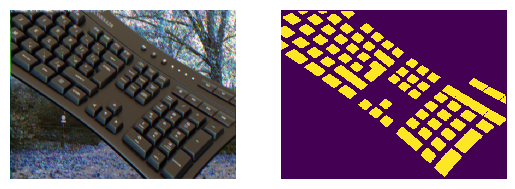

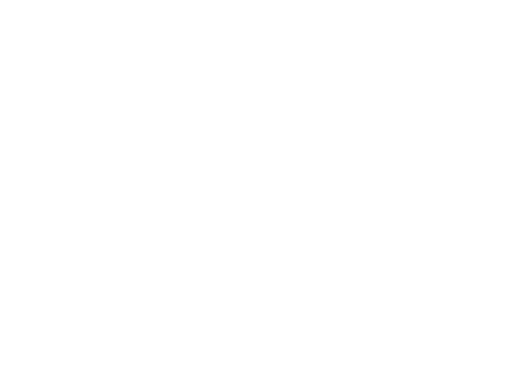

In [132]:
img, mask = test_dataset[random.randint(0, len(test_dataset) - 1)]
pred = model(img.cpu().unsqueeze(0)).detach().numpy()[0][0]

imshow(img, mask)
imshow((pred > 1).astype("uint8"))

In [117]:
model.to("mps")

BinarySegmentationModel(
  (model): UnetPlusPlus(
    (encoder): RegNetEncoder(
      (stem): ConvNormAct(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
      )
      (s1): RegStage(
        (b1): Bottleneck(
          (conv1): ConvNormAct(
            (conv): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
          )
          (conv2): ConvNormAct(
            (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            (bn): BatchNormAct2d(
              24, eps=1e-05, momentum=0.1, affine=True, trac

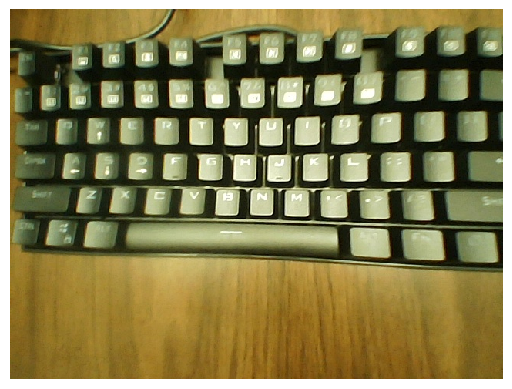

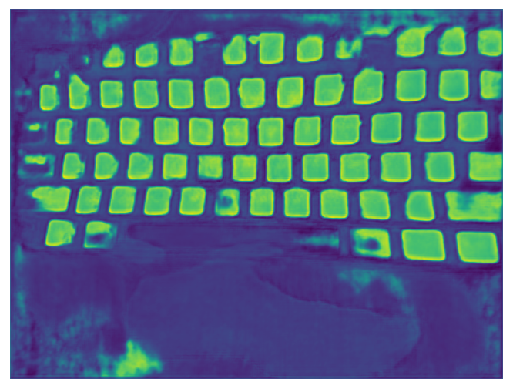

In [120]:
from torchvision.transforms import v2 as transforms
import numpy as np

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

i = 2
img = Image.open(f"datasets/test/{i}.jpg")
pred = model(transform(img).unsqueeze(0).to("mps")).detach()

pred = pred.cpu().numpy()[0][0]
img = np.array(img)

imshow(img)
imshow(pred)